### **Linear Separation and Trading Strategy**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [52]:
ba_volatility = pd.read_csv('ba_weekly_return_volatility.csv')
ba_detailed = pd.read_csv("ba_weekly_return_detailed.csv")

labels = ba_detailed[['Year','Week_Number', 'label']].drop_duplicates()

ba_volatility = ba_volatility.merge(
    labels, 
    on=['Year','Week_Number'], 
    how='inner'
)
ba_volatility.head()

,Year,Week_Number,mean_return,volatility,label
0,2020,0,-0.08400,0.118794,green
1,2020,1,-0.16120,1.584772,green
2,2020,2,-0.34560,1.269723,green
3,2020,3,-0.05525,2.818341,green
4,2020,4,-0.28880,1.510424,green


In [53]:
ba_volatility['mean_return'] = (ba_volatility['mean_return'] * 100).round(2)
ba_volatility['volatility'] = (ba_volatility['volatility'] * 100).round(2)

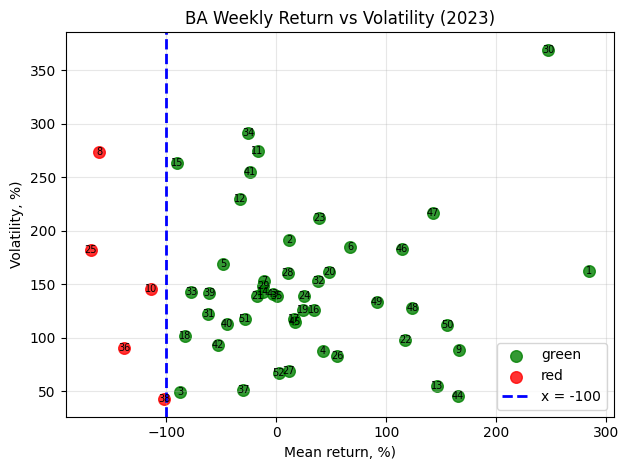

In [54]:
ba_year1 = ba_volatility[ba_volatility['Year'] == 2023].copy()
g = ba_year1[ba_year1['label'] == 'green']
r = ba_year1[ba_year1['label'] == 'red']

plt.figure()
plt.scatter(g['mean_return'], g['volatility'], label='green', alpha=0.8, color="green", s=70)
plt.scatter(r['mean_return'], r['volatility'], label='red', alpha=0.8, color="red", s=70)
for _, row in ba_year1.iterrows():
    plt.text(
        row['mean_return'], row['volatility'], 
        str(int(row['Week_Number'])), fontsize=7, 
        ha='center', va='center'
    )
    
ax = plt.gca()
ax.axvline(x=-100, color='blue', linestyle='--', linewidth=2, label='x = -100')
ax.set_xlabel('Mean return, %)')
ax.set_ylabel('Volatility, %)')
ax.set_title('BA Weekly Return vs Volatility (2023)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

By looking at the weekly plot in 2023, we can visually separate two labels, if mean return ≤ −100, stay in cash (red); otherwise, invest in stock (green).

The vertical cutoff line (x = −100) fully separates “risk-on” and “risk-off” weeks.

In [55]:
ba_year2 = ba_volatility[ba_volatility['Year'] == 2024].copy()
X = ba_year2[['mean_return', 'volatility']]
y = ba_year2['label'].apply(lambda x: 1 if x == 'green' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=79)

def set_label(df):
    if(df['mean_return']<=-100):
        return 0
    else:
        return 1
    
X_train['predicted'] = X_train.apply(set_label, axis=1)
X_test['predicted'] = X_test.apply(set_label, axis=1)
train_accuracy = (X_train['predicted'] == y_train).mean()
test_accuracy = (X_test['predicted'] == y_test).mean()
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

Train accuracy: 1.00, Test accuracy: 1.00


Our rule applies to 2024 as well, and it classifies all weeks correctly.

In [56]:
# final model on the whole 2024 data
ba_year2['predicted'] = ba_year2.apply(set_label, axis=1)
ba_year2['predicted'] = ba_year2['predicted'].map({1: 'green', 0: 'red'})
weekly_prices = (
    ba_detailed[ba_detailed['Year'] == 2024].groupby(['Year','Week_Number'], as_index=False)
    .agg(Open_w=('Open','first'), Close_w=('Close','last'))
    .sort_values(['Year','Week_Number'])
    .reset_index(drop=True)
)

weekly_prices_pred = weekly_prices.merge(ba_year2, on=['Year','Week_Number'], how='inner').sort_values(['Year','Week_Number']).reset_index(drop=True)
weekly_prices_pred.head()

,Year,Week_Number,Open_w,Close_w,mean_return,volatility,label,predicted
0,2024,0,257.279999,249.000000,-111.30,253.96,red,red
1,2024,1,228.000000,217.699997,-260.56,329.97,red,red
2,2024,2,210.070007,215.020004,-20.07,529.33,green,green
3,2024,3,213.070007,205.470001,-86.74,300.94,green,green
4,2024,4,206.059998,209.380005,40.98,286.72,green,green


In [57]:
# Trading Strategy
cash = 100
shares = 0
start_invested = False
results = {}


for i in range(len(weekly_prices_pred)-1):
    week = weekly_prices_pred.iloc[i]
    next_week = weekly_prices_pred.iloc[i+1]
    
    if(shares == 0):
        if((not start_invested) and week['predicted'] == "green"): #very first "green" week 
            shares = cash / week['Open_w']
            cash = 0
            start_invested = True
        elif(next_week['predicted'] == "green"):
            shares = cash / next_week['Open_w']
            cash = 0
    elif (shares > 0 and next_week['predicted'] == "red"):
        cash = shares * week['Close_w']
        shares = 0

# for last year
final_data = weekly_prices_pred.iloc[-1]
if(shares > 0):
    cash = shares * final_data['Close_w']
    shares = 0

print(round(cash, 2))
# print(shares)

162.39


By applying this weekly trading strategy (buy at week open when signal = 1, sell at week close when signal = 0), we achieved a profit of $162.39 in 2024.

The model is simple but effective; however, a perfect split in one period may not generalize to others.